In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 불러오기
- 스쿨존 사고 : accident
- 안전시설물

In [10]:
# 스쿨존 좌표 데이터 불러오기
school_zone    = pd.read_csv('./어린이보호구역_전처리1.csv', encoding='utf-8-sig')

In [3]:
# 스쿨존 사고 데이터 불러오기
accident = pd.read_csv('./스쿨존 사고 데이터 전처리/성남시전체_스쿨존_사고_전처리 - 성남시_스쿨존_반경300m_최종_전처리.csv')

In [ ]:
# 안전시설물 데이터 불러오기
base_path = './안전시설물 전처리/'
road_sign      = pd.read_csv(base_path + '도로안전표지_전처리1.csv', encoding='utf-8-sig')
red_surface    = pd.read_csv(base_path + '도로적색표면_전처리1.csv', encoding='utf-8-sig')
fence          = pd.read_csv(base_path + '무단횡단방지펜스_전처리1.csv', encoding='utf-8-sig')
speed_cam      = pd.read_csv(base_path + '무인교통단속카메라_전처리1.csv', encoding='utf-8-sig')
zone_sign      = pd.read_csv(base_path + '보호구역표지판_전처리1.csv', encoding='utf-8-sig')
cctv           = pd.read_csv(base_path + '생활안전CCTV_전처리1.csv', encoding='utf-8-sig')
signal         = pd.read_csv(base_path + '신호등_전처리1.csv', encoding='utf-8-sig')
yellow_carpet  = pd.read_csv(base_path + '옐로카펫_전처리1.csv', encoding='utf-8-sig')
crosswalk      = pd.read_csv(base_path + '횡단보도_전처리1.csv', encoding='utf-8-sig')

In [26]:
# 외부 안전 위험 요소 불러오기
shelter = pd.read_csv('./외부안전위험요소/성남시_아동안전지킴이집현황_전처리.csv')
lamp = pd.read_csv('../Raw-Data/외부 안전위험요소/raw_data/경기도 성남시_도로상 조명시설 지오태깅 데이터_20221216.csv', encoding='cp949')

### 함수 정의

In [ ]:
# 1. 두 좌표 간 거리 계산 함수
import glob
import os

def haversine_m(lat1, lon1, lat2, lon2):
    """
    두 좌표 사이의 거리를 미터(m) 단위로 반환.
    지구를 구체로 가정하는 Haversine 공식 사용.
    """
    R = 6371000  # 지구 반경 (미터)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

### 데이터 프레임 통합
- 기준은 어린이보호구역_전처리1.csv를 기준으로 함(사고 데이터의 학교를 기준으로 하면 없는 데이터가 많음)

#### 1) 안전시설물 개수 카운트

In [ ]:
# 각 변수를 리스트로 묶어서 한 번에 concat
facilities = pd.concat([
    road_sign, red_surface, fence, speed_cam,
    zone_sign, cctv, signal, yellow_carpet, crosswalk
], ignore_index=True)

# 결과: 시설물명 / 위도 / 경도 / 카테고리 컬럼 통합
print(facilities['카테고리'].value_counts())  # 카테고리별 개수 확인
print(f"총 시설물 수: {len(facilities)}")

카테고리
생활안전CCTV     3023
무단횡단방지펜스     1569
보호구역표지판      1343
신호등           904
도로적색표면        878
도로안전표지        695
횡단보도          691
무인교통단속카메라     310
옐로카펫           85
Name: count, dtype: int64
총 시설물 수: 9498


In [13]:
facilities.sample(5)

,시설물명,위도,경도,카테고리
5803,CCTV_중원성남-A-21,37.430907,127.127691,생활안전CCTV
9044,횡단보도_중원-100,37.414154,127.154815,횡단보도
7331,CCTV_분당판교-A-48,37.397327,127.097804,생활안전CCTV
9321,횡단보도_분당-241,37.386536,127.121227,횡단보도
5544,CCTV_수정위례-A-15,37.468500,127.138000,생활안전CCTV


In [14]:
school_zone.sample(5)

,시설물명,위도,경도,카테고리
125,성남생명숲어린이집,37.371025,127.115253,어린이보호구역
65,불곡초등학교,37.340984,127.119730,어린이보호구역
132,구미동어린이집,37.344538,127.112319,어린이보호구역
27,성남제일초등학교,37.438906,127.149609,어린이보호구역
51,이매초등학교,37.397210,127.126493,어린이보호구역


In [36]:
# 스쿨존별로 300m 이내 시설물 개수 카운트

RADIUS = 300  # 미터
categories = facilities['카테고리'].unique()

results = []

for _, school in school_zone.iterrows():
    # 해당 학교와 모든 시설물 간 거리 벡터 계산
    distances = haversine_m(
        school['위도'], school['경도'],
        facilities['위도'].values,
        facilities['경도'].values
    )
    
    # 300m 이내 시설물만 필터
    nearby = facilities[distances <= RADIUS]
    
    # 카테고리별 카운트
    counts = nearby['카테고리'].value_counts()
    
    row = {'시설물명': school['시설물명'], '위도': school['위도'], '경도': school['경도']}
    for cat in categories:
        row[cat] = counts.get(cat, 0)
    
    results.append(row)

result_df = pd.DataFrame(results)
result_df

,시설물명,위도,경도,도로안전표지,도로적색표면,무단횡단방지펜스,무인교통단속카메라,보호구역표지판,생활안전CCTV,신호등,옐로카펫,횡단보도
0,중원초등학교,37.437855,127.167857,0,5,12,0,15,18,0,1,0
1,하원초등학교,37.446255,127.170236,6,7,21,2,15,16,10,2,6
2,중부초등학교,37.451546,127.164951,2,19,25,2,26,27,4,1,2
3,상대원초등학교,37.442382,127.181591,2,8,30,1,21,5,3,1,2
4,도촌초등학교,37.414730,127.158024,5,9,26,1,10,6,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
137,성남혜은학교,37.450396,127.153922,5,21,18,5,24,26,7,3,6
138,성은특수학교,37.409122,127.143952,4,6,13,0,14,10,4,0,4
139,서울국제학교,37.465792,127.128438,1,4,6,1,8,16,1,0,1
140,케이디엘피어학원,37.389127,127.124549,7,7,16,2,15,11,10,0,9


In [37]:
# 스쿨존 시설물 카운트 결과 저장
result_df.to_csv('./스쿨존_시설물_300m_카운트.csv', index=False)

#### 2) 사고 데이터 통합
    1. 사고 데이터의 학교와 어린이보호

In [16]:
# 사고 데이터 통합?
# accident의 학교명 unique 추출
accident_schools = set(accident['대상시설명'].unique())

# result_df의 학교명 unique 추출
result_schools = set(result_df['시설물명'].unique())

# 일치 / 불일치 확인
matched     = accident_schools & result_schools       # 교집합
only_acc    = accident_schools - result_schools       # accident에만 있음
only_result = result_schools - accident_schools       # result_df에만 있음

print(f"총 accident 학교 수  : {len(accident_schools)}")
print(f"총 result_df 학교 수 : {len(result_schools)}")
print(f"일치하는 학교 수      : {len(matched)}")
print(f"accident에만 있는 수 : {len(only_acc)}")
print(f"result_df에만 있는 수: {len(only_result)}")

print("\n--- accident에만 있는 학교명 ---")
for s in sorted(only_acc):
    print(s)

print("\n--- result_df에만 있는 학교명 ---")
for s in sorted(only_result):
    print(s)


총 accident 학교 수  : 60
총 result_df 학교 수 : 142
일치하는 학교 수      : 60
accident에만 있는 수 : 0
result_df에만 있는 수: 82

--- accident에만 있는 학교명 ---

--- result_df에만 있는 학교명 ---
갈보리어린이집
건영장안유치원
검단초등학교
고등나래 유치원
구미동어린이집
꿈터 유치원
낙생초등학교
내정초등학교
늘푸른초등학교
다솜어린이집
단대어린이집
당촌초등학교
대하초등학교
도촌유치원
도촌초등학교
미금초등학교
배성유치원
백현초등학교
보듬이나눔이어린이집
보평초등학교
복정2어린이집
복정어린이집
복정초등학교
분당어린이집
분당중앙유치원
불곡초등학교
불정초등학교
산성3어린이집
산운초등학교
삼평어린이집
상대원초등학교
상탑초등학교
샛별유치원
서광어린이집
서당초등학교
서울국제학교
성남매송초등학교
성남생명숲어린이집
성남서초등학교
성남송현초등학교
성남신기초등학교
성남신흥초등학교
성남양지초등학교
성남여수초등학교
성남장안초등학교
성남정자초등학교
성남화랑초등학교
성마르코유치원
성모 유치원
성은특수학교
세화유치원
숲리라유치원
신백현초등학교
안촌 유치원
양영초등학교
오리초등학교
왕남초등학교
운중초등학교
운중하나어린이집
위례고운초등학교
위례새초롱유치원
위례중앙초등학교
위례푸른초등학교
위례하늘유치원
위례한빛초등학교
은솔유치원
은혜유치원
창조유치원
청솔초등학교
탄천초등학교
판교대장초등학교
판교샘유치원
판교어린이집
판교제2어린이집
판교초등학교
푸르니이매어린이집
하원초등학교
한솔초등학교
해나유치원
휴맥스어린이집
희망대초등학교
희영유치원


In [30]:
# 
lamp.head()
lamp.rename(columns={'위도(LATITUDE)': '위도', '경도(LONGITUDE)': '경도'}, inplace=True)
lamp.head()

,순번(NO),구분(LAMP),일련번호(SER),위도,경도
0,1,2,고기로-1,37.352327,127.082932
1,2,2,고기로-2,37.352327,127.082932
2,3,2,고기로-3,37.352327,127.082932
3,4,2,구미로-1,37.343812,127.124693
4,5,2,구미로-2,37.343812,127.124693


In [31]:
# 각 조명마다 가장 가까운 학교 찾기
def find_nearest_school(lamp_row, school_zone):
    distances = haversine_m(
        lamp_row['위도'], lamp_row['경도'],
        school_zone['위도'].values,
        school_zone['경도'].values
    )
    nearest_idx = np.argmin(distances)           # 가장 가까운 학교 인덱스
    nearest_dist = distances[nearest_idx]        # 그 거리
    nearest_name = school_zone.iloc[nearest_idx]['시설물명']  # 학교명

    # 300m 초과면 None 반환 (스쿨존 외부)
    return nearest_name if nearest_dist <= 300 else None

lamp['시설물명'] = lamp.apply(lambda row: find_nearest_school(row, school_zone), axis=1)

print(lamp['시설물명'].isna().sum(), "개는 반경 300m 내 학교 없음")
lamp.head()

16379 개는 반경 300m 내 학교 없음


,순번(NO),구분(LAMP),일련번호(SER),위도,경도,시설물명
0,1,2,고기로-1,37.352327,127.082932,None
1,2,2,고기로-2,37.352327,127.082932,None
2,3,2,고기로-3,37.352327,127.082932,None
3,4,2,구미로-1,37.343812,127.124693,None
4,5,2,구미로-2,37.343812,127.124693,None


시설물 데이터 eda

In [34]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   시설물명       142 non-null    object 
 1   위도         142 non-null    float64
 2   경도         142 non-null    float64
 3   도로안전표지     142 non-null    int64  
 4   도로적색표면     142 non-null    int64  
 5   무단횡단방지펜스   142 non-null    int64  
 6   무인교통단속카메라  142 non-null    int64  
 7   보호구역표지판    142 non-null    int64  
 8   생활안전CCTV   142 non-null    int64  
 9   신호등        142 non-null    int64  
 10  옐로카펫       142 non-null    int64  
 11  횡단보도       142 non-null    int64  
dtypes: float64(2), int64(9), object(1)
memory usage: 13.4+ KB


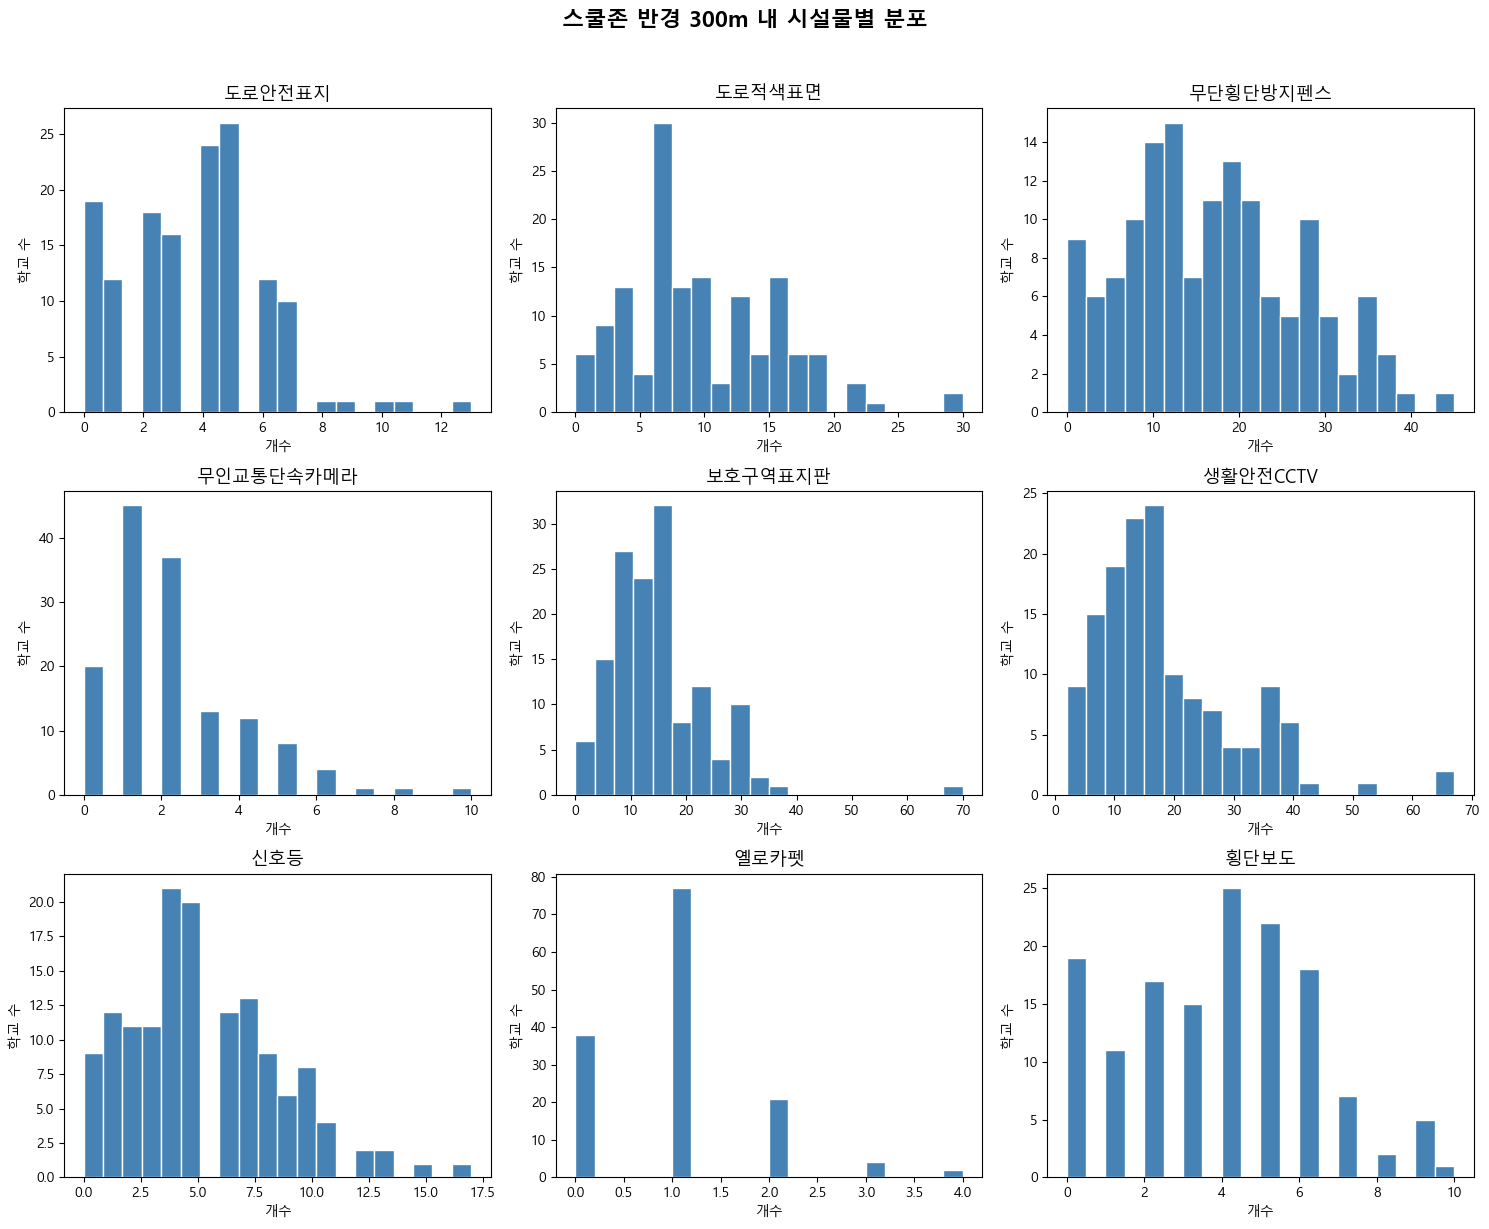

In [35]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac
plt.rcParams['axes.unicode_minus'] = False

# 시설물 컬럼만 추출
facility_cols = ['도로안전표지', '도로적색표면', '무단횡단방지펜스', '무인교통단속카메라',
                 '보호구역표지판', '생활안전CCTV', '신호등', '옐로카펫', '횡단보도']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(facility_cols):
    axes[i].hist(result_df[col], bins=20, color='steelblue', edgecolor='white')
    axes[i].set_title(col, fontsize=13)
    axes[i].set_xlabel('개수')
    axes[i].set_ylabel('학교 수')

plt.suptitle('스쿨존 반경 300m 내 시설물별 분포', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()